## DC2 Bootstrap Testing with Full Image

In [1]:
import torch
import numpy as np
from os import environ
from pathlib import Path
from einops import rearrange
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from hydra import initialize, compose
from hydra.utils import instantiate

from bliss.surveys.dc2 import DC2, unsqueeze_tile_dict
from pathlib import Path

from bliss.catalog import FullCatalog, TileCatalog
from torch.utils.data import RandomSampler, DataLoader

from torchmetrics import MetricCollection
from torch.nn.utils.rnn import pad_sequence
import tqdm
from pytorch_lightning.utilities import move_data_to_device
from bliss.catalog import SourceType

import GCRCatalogs

environ["BLISS_HOME"] = str(Path().resolve().parents[1])

output_dir = Path("./DC2_bootstrap_full_image_output/")
output_dir.mkdir(parents=True, exist_ok=True)

In [2]:
with initialize(config_path=".", version_base=None):
    notebook_cfg = compose("notebook_config")

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

In [3]:
dc2: DC2 = instantiate(notebook_cfg.surveys.dc2)
test_sample = dc2.get_plotting_sample(0)
cur_image_wcs = test_sample["wcs"]
cur_image_true_full_catalog = test_sample["full_catalog"]
cur_image_match_id = test_sample["match_id"]

In [4]:
GCRCatalogs.set_root_dir("/data/dc2/")
lsst_catalog_gcr = GCRCatalogs.load_catalog("desc_dc2_run2.2i_dr6_object_with_truth_match")
lsst_catalog_sub = lsst_catalog_gcr.get_quantities(
    [
        "id_truth",
        "objectId",
        "ra",
        "dec",
        "truth_type",
        "cModelFlux_u",
        "cModelFluxErr_u",
        "cModelFlux_g",
        "cModelFluxErr_g",
        "cModelFlux_r",
        "cModelFluxErr_r",
        "cModelFlux_i",
        "cModelFluxErr_i",
        "cModelFlux_z",
        "cModelFluxErr_z",
        "cModelFlux_y",
        "cModelFluxErr_y",
    ]
)
lsst_catalog_df = pd.DataFrame(lsst_catalog_sub)
lsst_catalog_tensors_dict = {
    "truth_type": torch.tensor(lsst_catalog_df["truth_type"].values).view(-1, 1),
    "flux": torch.cat(
        [
            torch.tensor(flux.values).view(-1, 1)
            for flux in [
                lsst_catalog_df["cModelFlux_g"],
                lsst_catalog_df["cModelFlux_i"],
                lsst_catalog_df["cModelFlux_r"],
                lsst_catalog_df["cModelFlux_u"],
                lsst_catalog_df["cModelFlux_y"],
                lsst_catalog_df["cModelFlux_z"],
            ]
        ],
        dim=1,
    ),
    "ra": torch.tensor(lsst_catalog_df["ra"].values),
    "dec": torch.tensor(lsst_catalog_df["dec"].values),
}

In [5]:
def get_lsst_params(
    lsst_catalog_tensors_dict, cur_image_wcs, image_lim,
):
    lsst_ra = lsst_catalog_tensors_dict["ra"]
    lsst_dec = lsst_catalog_tensors_dict["dec"]
    lsst_pt, lsst_pr = cur_image_wcs.all_world2pix(lsst_ra, lsst_dec, 0)
    lsst_pt = torch.from_numpy(lsst_pt)
    lsst_pr = torch.from_numpy(lsst_pr)

    lsst_plocs = torch.stack((lsst_pr, lsst_pt), dim=-1)
    lsst_source_type = lsst_catalog_tensors_dict["truth_type"]
    lsst_flux = lsst_catalog_tensors_dict["flux"]

    x0_mask = (lsst_plocs[:, 0] > 0) & (lsst_plocs[:, 0] < image_lim)
    x1_mask = (lsst_plocs[:, 1] > 0) & (lsst_plocs[:, 1] < image_lim)
    lsst_x_mask = x0_mask * x1_mask
    # filter r band
    lsst_flux_mask = lsst_flux[:, 2] > 0
    # filter supernova
    lsst_source_mask = (lsst_source_type != 3).squeeze(1)
    lsst_mask = lsst_x_mask * lsst_flux_mask * lsst_source_mask

    lsst_plocs = lsst_plocs[lsst_mask, :]
    lsst_source_type = torch.where(
        lsst_source_type[lsst_mask] == 2, SourceType.STAR, SourceType.GALAXY
    )
    lsst_flux = lsst_flux[lsst_mask, :]

    return lsst_plocs, lsst_source_type, lsst_flux

In [6]:
image_lim = test_sample["image"].shape[1]
r_band_min_flux = notebook_cfg.encoder.min_flux_threshold_during_test
lsst_plocs, lsst_source_type, lsst_flux = get_lsst_params(
    lsst_catalog_tensors_dict, cur_image_wcs, image_lim)
flux_mask = lsst_flux[:, 2] > r_band_min_flux
lsst_plocs = lsst_plocs[flux_mask, :]
lsst_source_type = lsst_source_type[flux_mask]
lsst_flux = lsst_flux[flux_mask, :]
lsst_n_sources = torch.tensor([lsst_plocs.shape[0]])

In [7]:
lsst_full_cat = FullCatalog(height=image_lim, width=image_lim, d={
        "plocs": lsst_plocs.unsqueeze(0).to(device=device),
        "n_sources": lsst_n_sources.to(device=device),
        "source_type": lsst_source_type.unsqueeze(0).to(device=device),
        "galaxy_fluxes": lsst_flux.unsqueeze(0).to(device=device),
        "star_fluxes": lsst_flux.unsqueeze(0).clone().to(device=device),
    })

In [8]:
# change this model path according to your training setting
MODEL_PATH = "../../output/DC2_experiments/DC2_psf_aug_asinh_05-30-2/checkpoints/best_encoder.ckpt"
bliss_encoder = instantiate(notebook_cfg.encoder).to(device=device)
pretrained_weights = torch.load(MODEL_PATH, device)["state_dict"]
bliss_encoder.load_state_dict(pretrained_weights)
bliss_encoder.eval();

In [9]:
batch = {
    "tile_catalog": unsqueeze_tile_dict(test_sample["tile_catalog"]),
    "images": rearrange(test_sample["image"], "h w nw -> 1 h w nw"),
    "background": rearrange(test_sample["background"], "h w nw -> 1 h w nw"),
    "psf_params": rearrange(test_sample["psf_params"], "h w -> 1 h w")
}

batch = move_data_to_device(batch, device=device)

bliss_output_path = output_dir / "bliss_output.pkl"

if not bliss_output_path.exists():
    bliss_out_dict = bliss_encoder.predict_step(batch, None)

    with open(bliss_output_path, "wb") as outp:  # Overwrites any existing file.
        pickle.dump(bliss_out_dict, outp, pickle.HIGHEST_PROTOCOL)
else:
    with open(bliss_output_path, "rb") as inputp:
        bliss_out_dict = pickle.load(inputp)

In [10]:
bliss_full_cat: FullCatalog = bliss_out_dict["mode_cat"].to_full_catalog()

In [11]:
matcher = instantiate(notebook_cfg.encoder.matcher)
bliss_metrics = instantiate(notebook_cfg.encoder.metrics)
lsst_metrics = bliss_metrics.clone()
bliss_metrics = MetricCollection({
    "detection_performance": bliss_metrics["detection_performance"],
    "detection_performance_star": bliss_metrics["detection_performance_star"],
    "detection_performance_galaxy": bliss_metrics["detection_performance_galaxy"],
}).to(device=device)
lsst_metrics = MetricCollection({
    "detection_performance": lsst_metrics["detection_performance"],
    "detection_performance_star": lsst_metrics["detection_performance_star"],
    "detection_performance_galaxy": lsst_metrics["detection_performance_galaxy"],
}).to(device=device)

bliss_results = {
    "detection_recall": [],
    "detection_recall_star": [],
    "detection_recall_galaxy": [],
    "detection_precision": [],
    "detection_precision_star": [],
    "detection_precision_galaxy": [],
    "detection_f1": [],
    "detection_f1_star": [],
    "detection_f1_galaxy": [],
}

lsst_results = {
    "detection_recall": [],
    "detection_recall_star": [],
    "detection_recall_galaxy": [],
    "detection_precision": [],
    "detection_precision_star": [],
    "detection_precision_galaxy": [],
    "detection_f1": [],
    "detection_f1_star": [],
    "detection_f1_galaxy": [],
}

bootstrap_result_path = output_dir / "bootstrap_result.pkl"
if not bootstrap_result_path.exists():
    epochs_num = 10
    plocs_box_len = 400
    plocs_boxes_num = (image_lim // plocs_box_len) ** 2
    for epoch in tqdm.tqdm(range(epochs_num), unit="epoch"):
        for i in range(plocs_boxes_num):
            plocs_box_origin = torch.rand(2) * (image_lim - plocs_box_len)
            cur_bliss_full_catalog = bliss_full_cat.filter_full_catalog_by_ploc_box(plocs_box_origin, plocs_box_len)
            cur_lsst_full_catalog = lsst_full_cat.filter_full_catalog_by_ploc_box(plocs_box_origin, plocs_box_len)
            cur_target_catalog = cur_image_true_full_catalog.filter_full_catalog_by_ploc_box(plocs_box_origin, plocs_box_len)

            bliss_matching = matcher.match_catalogs(cur_target_catalog, cur_bliss_full_catalog)
            bliss_metrics.update(cur_target_catalog, cur_bliss_full_catalog, bliss_matching)

            lsst_matching = matcher.match_catalogs(cur_target_catalog, cur_lsst_full_catalog)
            lsst_metrics.update(cur_target_catalog, cur_lsst_full_catalog, lsst_matching)

        for k, v in bliss_metrics.items():
            resutls = v.get_results_on_per_flux_bin()
            for k_results, v_results in resutls.items():
                bliss_results[k_results].append(v_results.cpu())

        for k, v in lsst_metrics.items():
            resutls = v.get_results_on_per_flux_bin()
            for k_results, v_results in resutls.items():
                lsst_results[k_results].append(v_results.cpu())

        bliss_metrics.reset()
        lsst_metrics.reset()

    with open(bootstrap_result_path, "wb") as bootstrap_result_file:
            pickle.dump({
                "bliss_results": bliss_results,
                "lsst_results": lsst_results,
            }, bootstrap_result_file, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open(bootstrap_result_path, "rb") as bootstrap_result_file:
          bootstrap_result = pickle.load(bootstrap_result_file)
    bliss_results = bootstrap_result["bliss_results"]
    lsst_results = bootstrap_result["lsst_results"]

In [12]:
def plot_with_error_bars(recall_list_1, precision_list_1, f1_list_1,
                         recall_list_2, precision_list_2, f1_list_2,
                         mag_bin_cutoffs, exclude_last_bin, bin_unit_is_flux,
                         source_type_name, 
                         model_name_1, model_name_2):
    quantile_points = torch.tensor([0.05, 0.5, 0.95])

    recall_matrix_1 = torch.stack(recall_list_1).quantile(q=quantile_points, dim=0)
    recall_matrix_1[0, :] = (recall_matrix_1[0, :] - recall_matrix_1[1, :]).abs()
    recall_matrix_1[2, :] = recall_matrix_1[2, :] - recall_matrix_1[1, :]
    precision_matrix_1 = torch.stack(precision_list_1).quantile(q=quantile_points, dim=0)
    precision_matrix_1[0, :] = (precision_matrix_1[0, :] - precision_matrix_1[1, :]).abs()
    precision_matrix_1[2, :] = precision_matrix_1[2, :] - precision_matrix_1[1, :]
    f1_matrix_1 = torch.stack(f1_list_1).quantile(q=quantile_points, dim=0)
    f1_matrix_1[0, :] = (f1_matrix_1[0, :] - f1_matrix_1[1, :]).abs()
    f1_matrix_1[2, :] = f1_matrix_1[2, :] - f1_matrix_1[1, :]

    recall_matrix_2 = torch.stack(recall_list_2).quantile(q=quantile_points, dim=0)
    recall_matrix_2[0, :] = (recall_matrix_2[0, :] - recall_matrix_2[1, :]).abs()
    recall_matrix_2[2, :] = recall_matrix_2[2, :] - recall_matrix_2[1, :]
    precision_matrix_2 = torch.stack(precision_list_2).quantile(q=quantile_points, dim=0)
    precision_matrix_2[0, :] = (precision_matrix_2[0, :] - precision_matrix_2[1, :]).abs()
    precision_matrix_2[2, :] = precision_matrix_2[2, :] - precision_matrix_2[1, :]
    f1_matrix_2 = torch.stack(f1_list_2).quantile(q=quantile_points, dim=0)
    f1_matrix_2[0, :] = (f1_matrix_2[0, :] - f1_matrix_2[1, :]).abs()
    f1_matrix_2[2, :] = f1_matrix_2[2, :] - f1_matrix_2[1, :]

    xlabels = (
        ["[100, " + str(mag_bin_cutoffs[0]) + "]"]
        + [f"[{mag_bin_cutoffs[i]}, {mag_bin_cutoffs[i + 1]}]" for i in range(len(mag_bin_cutoffs) - 1)]
        + ["> " + str(mag_bin_cutoffs[-1])]
    )

    if exclude_last_bin:
        precision_matrix_1 = precision_matrix_1[:, :-1]
        recall_matrix_1 = recall_matrix_1[:, :-1]
        f1_matrix_1 = f1_matrix_1[:, :-1]
        precision_matrix_2 = precision_matrix_2[:, :-1]
        recall_matrix_2 = recall_matrix_2[:, :-1]
        f1_matrix_2 = f1_matrix_2[:, :-1]
        xlabels = xlabels[:-1]

    sns.set_theme(style="whitegrid")
    fig, axes = plt.subplots(
        1, 3, figsize=(30, 10), sharey=True
    )

    c1, c2 = plt.rcParams["axes.prop_cycle"].by_key()["color"][0:2]
    axes[0].errorbar(
        range(len(xlabels)),
        recall_matrix_1[1, :].tolist(),
        yerr=recall_matrix_1[(0, 2), :],
        fmt="-o",
        color=c1,
        label=f"{model_name_1} Recall ({source_type_name})",
    )
    axes[0].errorbar(
        range(len(xlabels)),
        recall_matrix_2[1, :].tolist(),
        yerr=recall_matrix_2[(0, 2), :],
        fmt="-o",
        color=c2,
        label=f"{model_name_2} Recall ({source_type_name})",
    )
    axes[0].set_xlabel("Flux" if bin_unit_is_flux else "Magnitudes")
    axes[0].set_xticks(range(len(xlabels)))
    axes[0].set_xticklabels(xlabels, rotation=45)
    axes[0].legend()

    axes[1].errorbar(
        range(len(xlabels)),
        precision_matrix_1[1, :].tolist(),
        yerr=precision_matrix_1[(0, 2), :],
        fmt="-o",
        color=c1,
        label=f"{model_name_1} Precision ({source_type_name})",
    )
    axes[1].errorbar(
        range(len(xlabels)),
        precision_matrix_2[1, :].tolist(),
        yerr=precision_matrix_2[(0, 2), :],
        fmt="-o",
        color=c2,
        label=f"{model_name_2} Precision ({source_type_name})",
    )
    axes[1].set_xlabel("Flux" if bin_unit_is_flux else "Magnitudes")
    axes[1].set_xticks(range(len(xlabels)))
    axes[1].set_xticklabels(xlabels, rotation=45)
    axes[1].legend()

    axes[2].errorbar(
        range(len(xlabels)),
        f1_matrix_1[1, :].tolist(),
        yerr=f1_matrix_1[(0, 2), :],
        fmt="-o",
        color=c1,
        label=f"{model_name_1} F1 ({source_type_name})",
    )
    axes[2].errorbar(
        range(len(xlabels)),
        f1_matrix_2[1, :].tolist(),
        yerr=f1_matrix_2[(0, 2), :],
        fmt="-o",
        color=c2,
        label=f"{model_name_2} F1 ({source_type_name})",
    )
    axes[2].set_xlabel("Flux" if bin_unit_is_flux else "Magnitudes")
    axes[2].set_xticks(range(len(xlabels)))
    axes[2].set_xticklabels(xlabels, rotation=45)
    axes[2].legend()

    plt.tight_layout()
    plt.show()

    return fig, axes

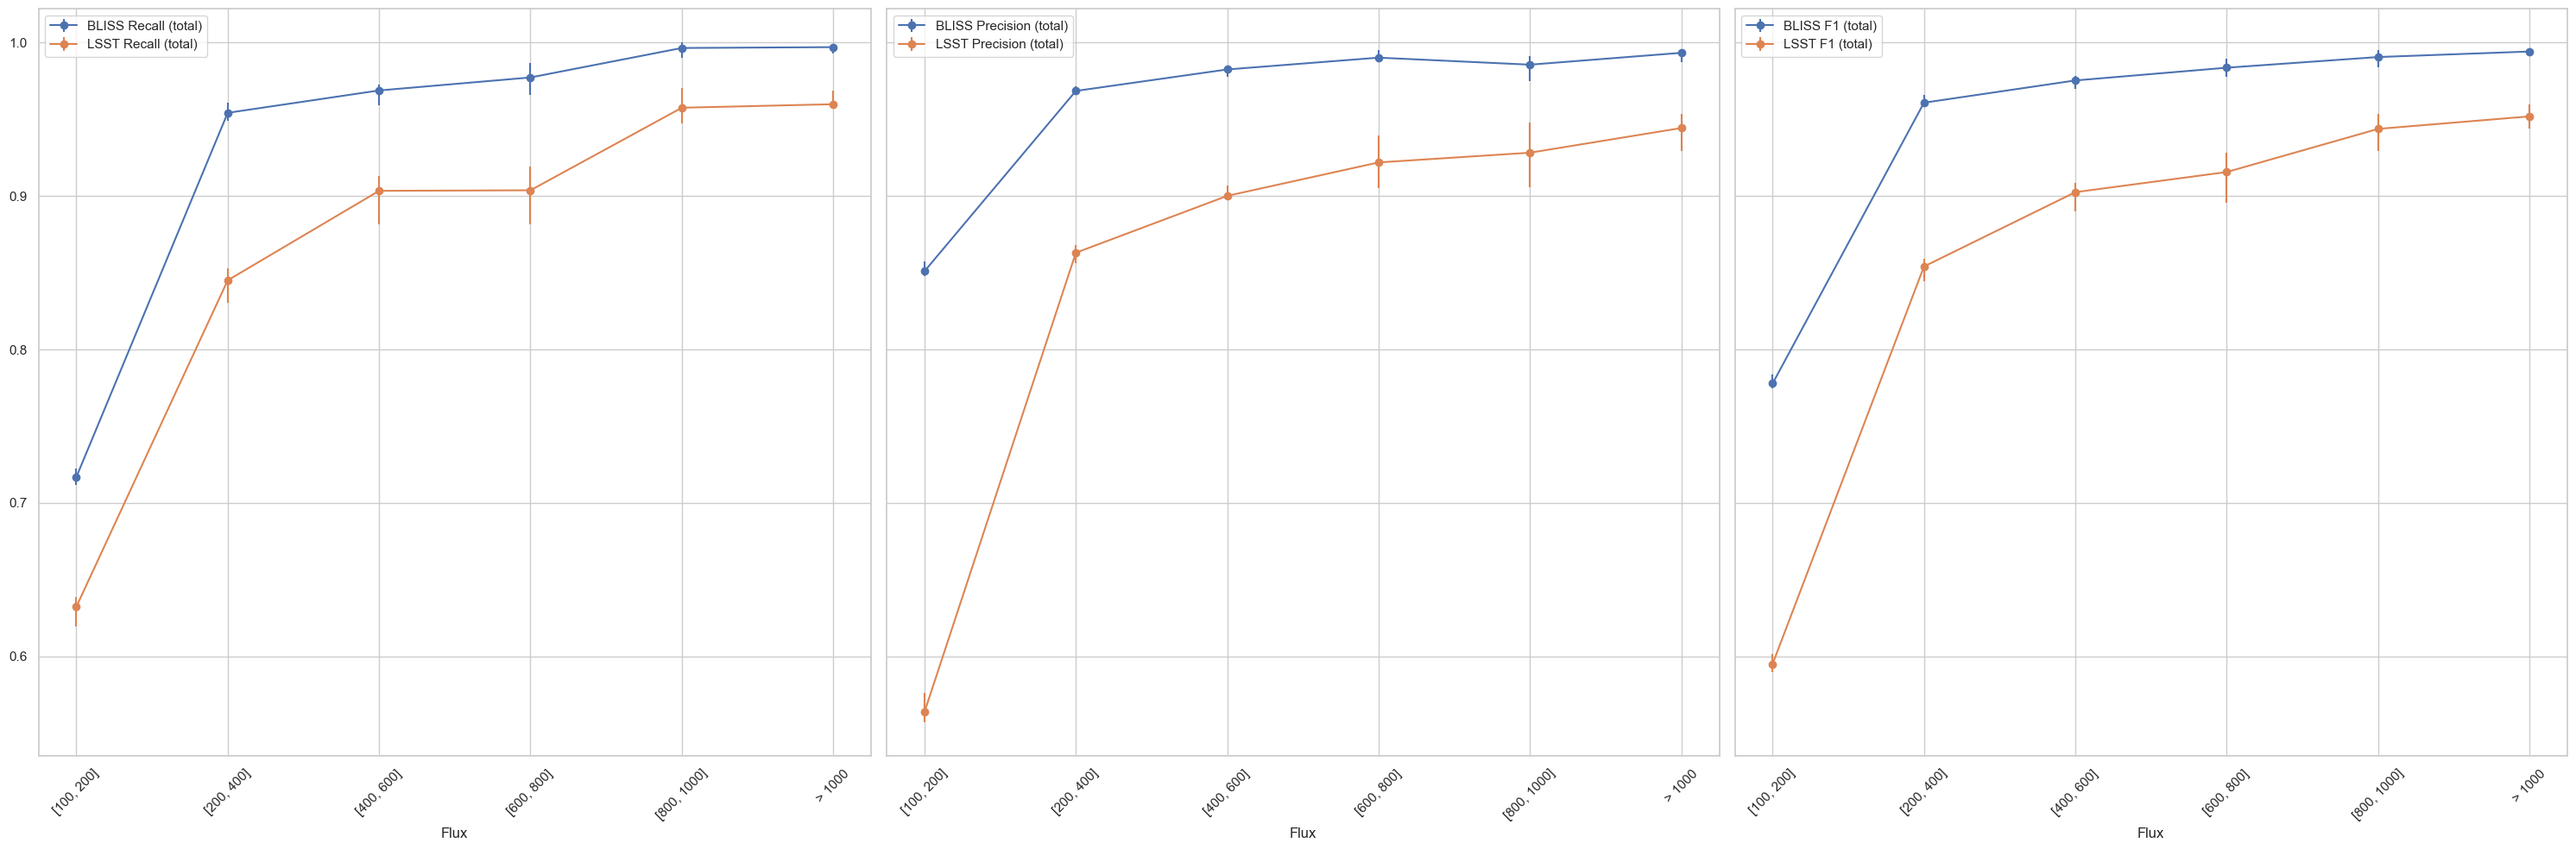

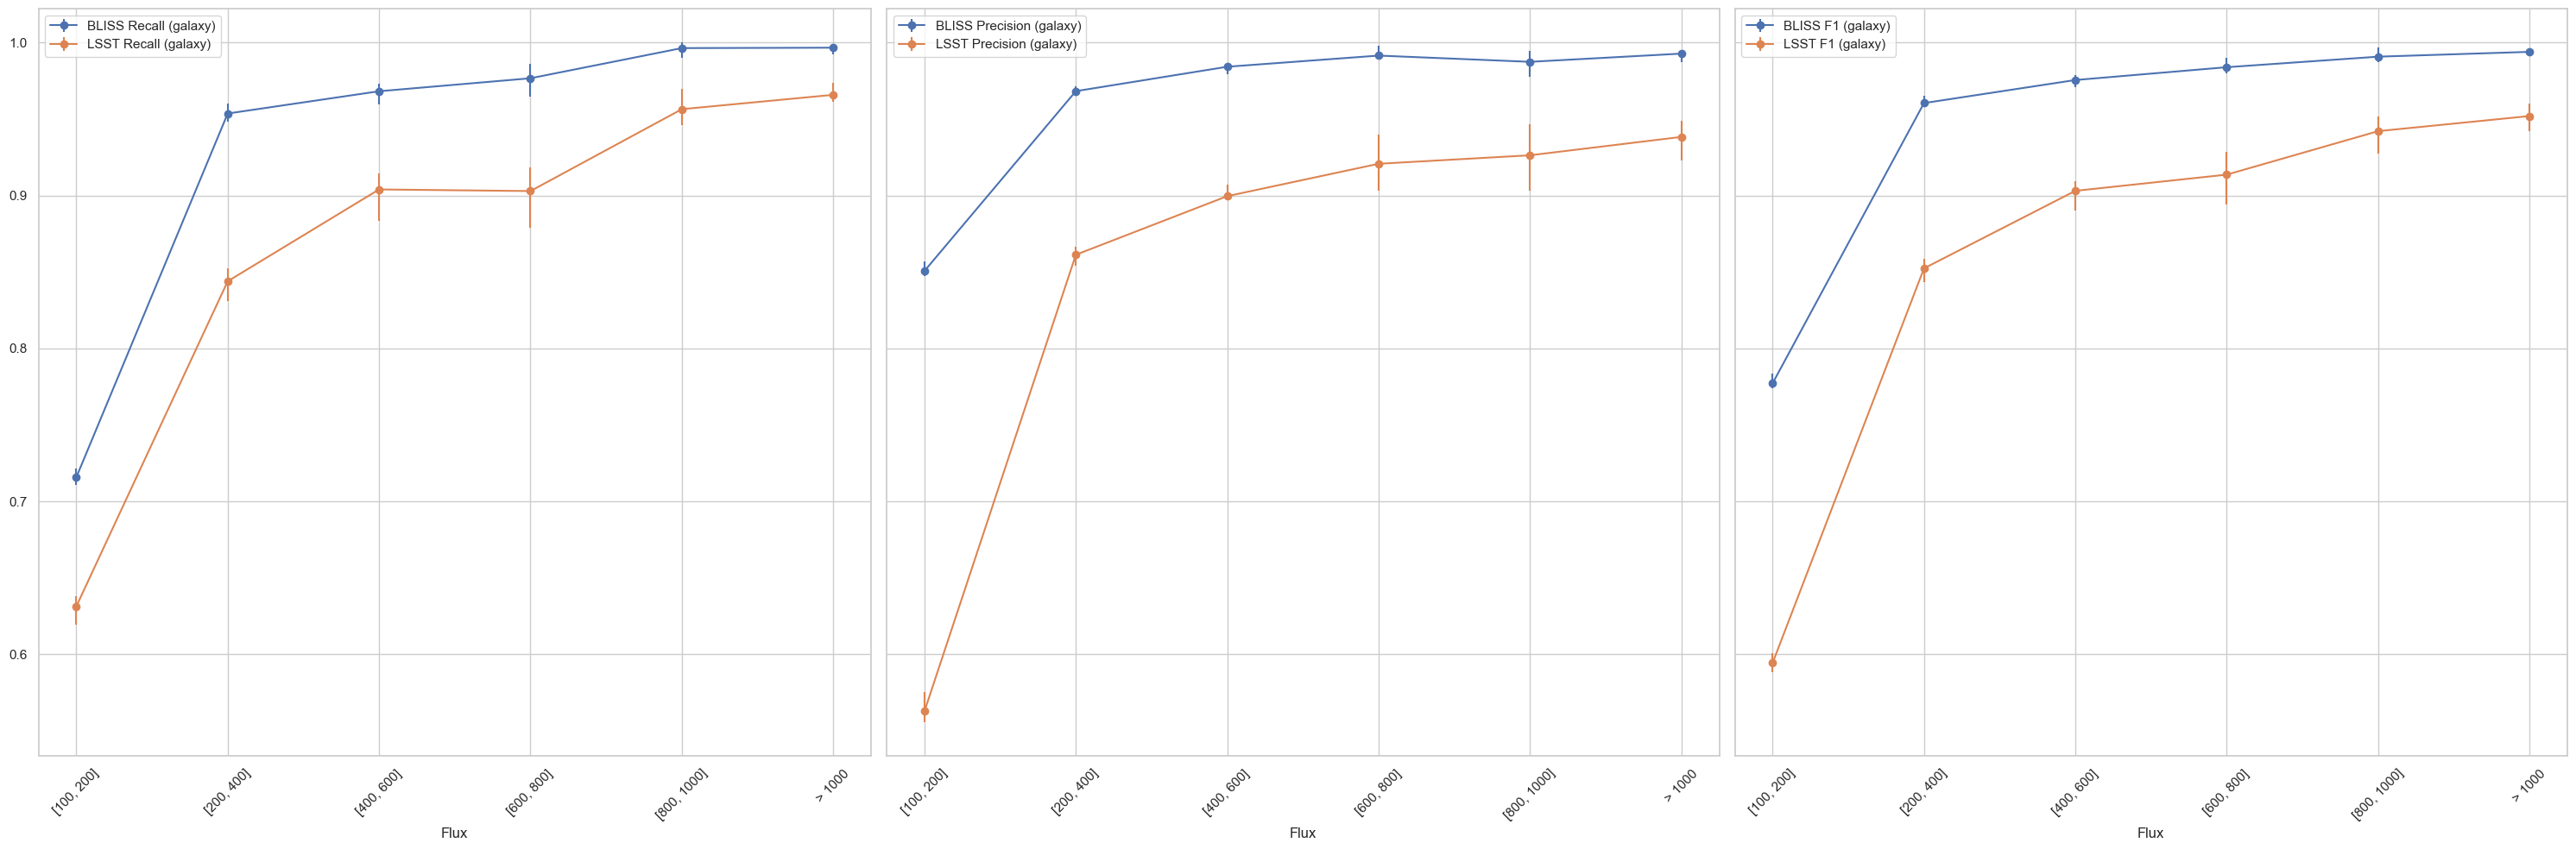

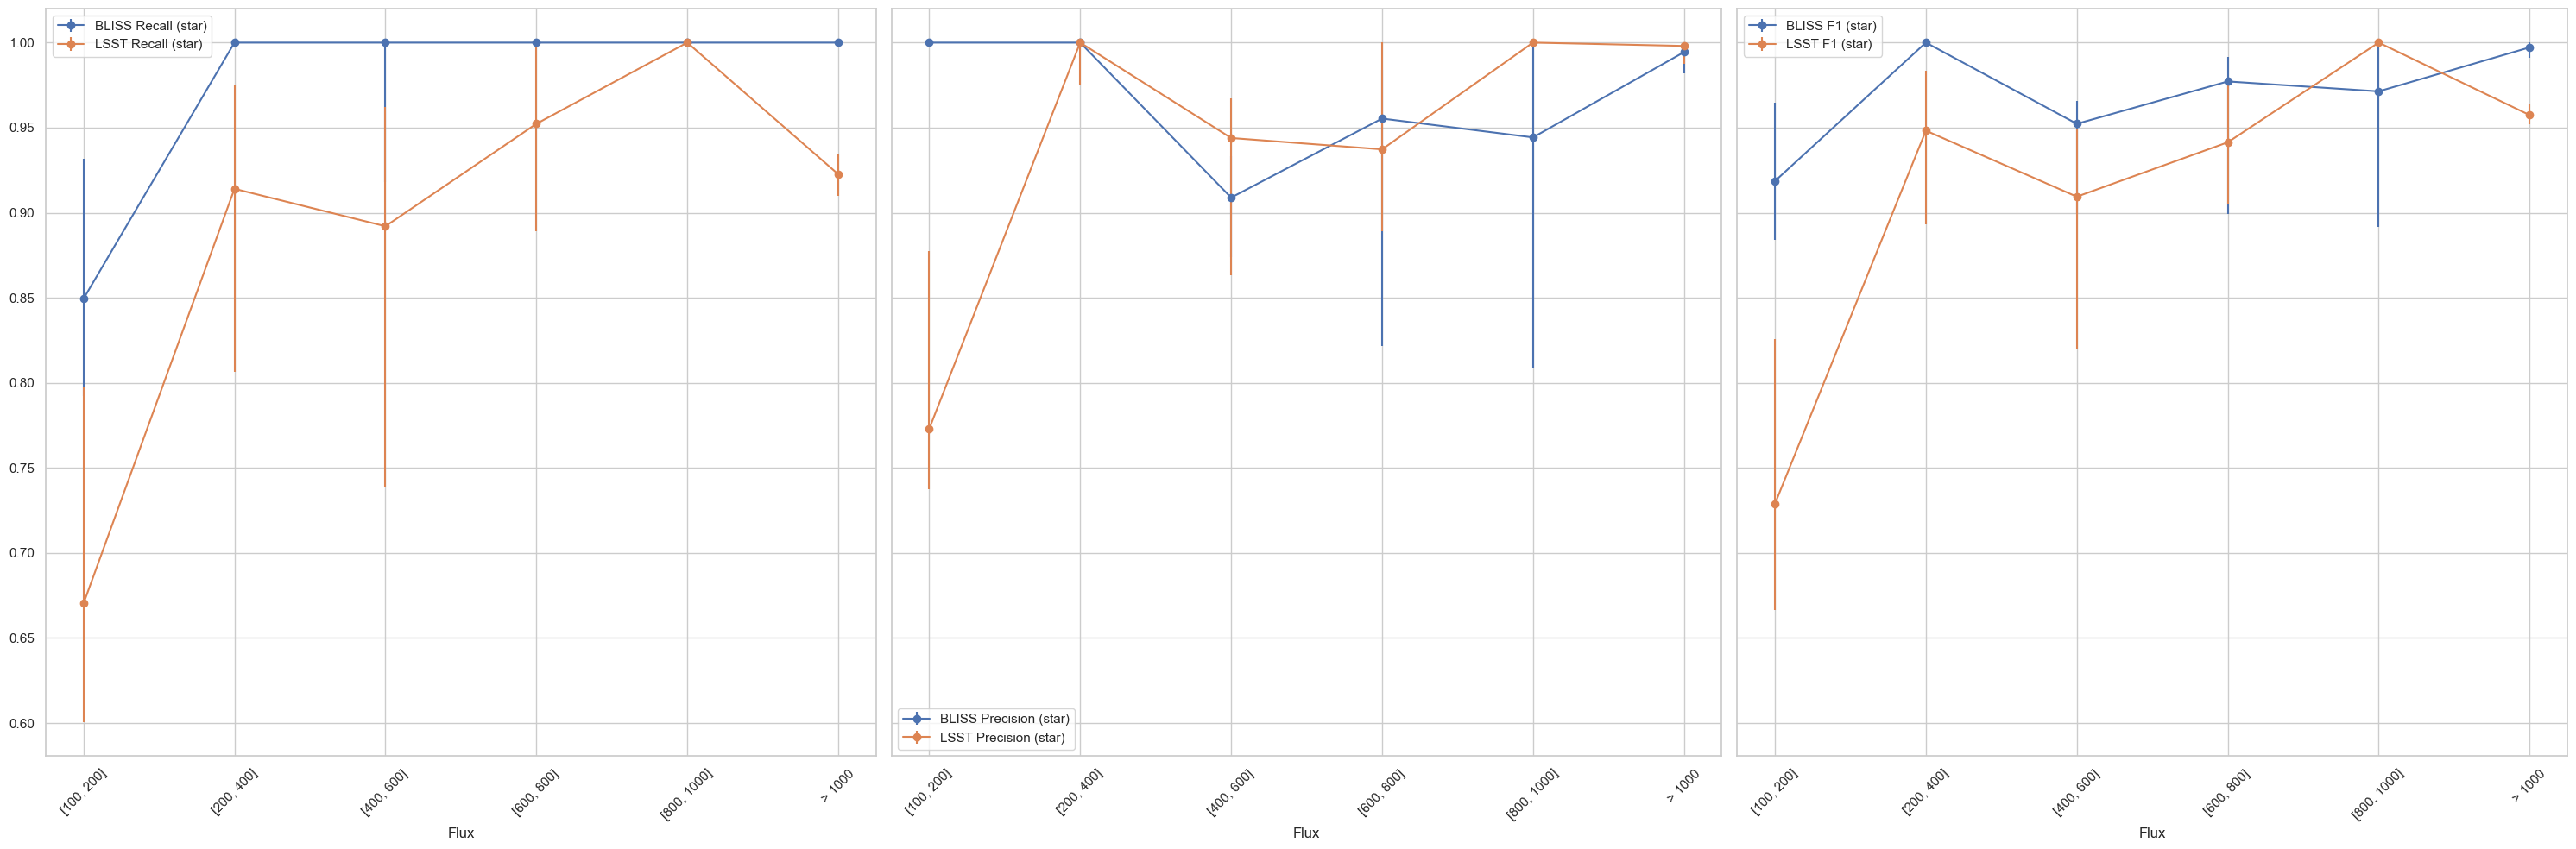

In [13]:
for k, v in bliss_metrics.items():
    if k == "detection_performance":
        fig, axes = plot_with_error_bars(bliss_results["detection_recall"],
                                        bliss_results["detection_precision"],
                                        bliss_results["detection_f1"],
                                        lsst_results["detection_recall"],
                                        lsst_results["detection_precision"],
                                        lsst_results["detection_f1"],
                                        mag_bin_cutoffs=v.mag_bin_cutoffs,
                                        exclude_last_bin=v.exclude_last_bin,
                                        bin_unit_is_flux=v.bin_unit_is_flux,
                                        source_type_name=v.source_type_name,
                                        model_name_1="BLISS",
                                        model_name_2="LSST")
    elif k == "detection_performance_star":
        fig, axes = plot_with_error_bars(bliss_results["detection_recall_star"],
                                        bliss_results["detection_precision_star"],
                                        bliss_results["detection_f1_star"],
                                        lsst_results["detection_recall_star"],
                                        lsst_results["detection_precision_star"],
                                        lsst_results["detection_f1_star"],
                                        mag_bin_cutoffs=v.mag_bin_cutoffs,
                                        exclude_last_bin=v.exclude_last_bin,
                                        bin_unit_is_flux=v.bin_unit_is_flux,
                                        source_type_name=v.source_type_name,
                                        model_name_1="BLISS",
                                        model_name_2="LSST")
    elif k == "detection_performance_galaxy":
        fig, axes = plot_with_error_bars(bliss_results["detection_recall_galaxy"],
                                        bliss_results["detection_precision_galaxy"],
                                        bliss_results["detection_f1_galaxy"],
                                        lsst_results["detection_recall_galaxy"],
                                        lsst_results["detection_precision_galaxy"],
                                        lsst_results["detection_f1_galaxy"],
                                        mag_bin_cutoffs=v.mag_bin_cutoffs,
                                        exclude_last_bin=v.exclude_last_bin,
                                        bin_unit_is_flux=v.bin_unit_is_flux,
                                        source_type_name=v.source_type_name,
                                        model_name_1="BLISS",
                                        model_name_2="LSST")
    else:
        raise NotImplementedError()
    
    fig.show()